# <h1 align=center> **ETL - HISTÓRICO DE PRECIOS** </h1>
## <h1 align=center> (Extract, Transform, Load) </h1>

Para el desarrollo de la primera fase de este proyecto, realizaré la aplicación del proceso ETL, el cuál básicamente consiste en `“Extraer”` los datos crudos desde su origen (Source), `“Transformarlos”` según nuestras necesidades de analítica o la estructura que deseamos y `“Cargarlos”` a una base de datos orientada a procesos analíticos (Target).

<p align=center><img src='..\Imagenes\precio_criptomonedas.jpg' height=300><p>
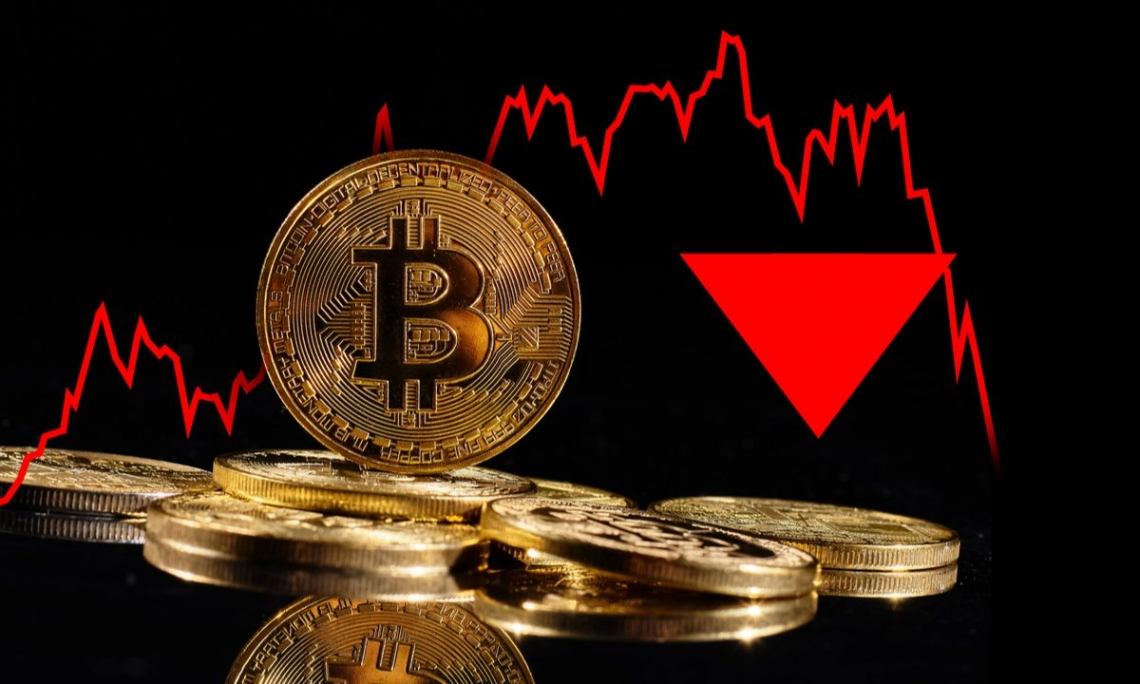 height=300

Como fase previa a la aplicación del ETL, se realizará la importación de librerías que serán de utilidad en el desarrollo del proceso, las cuales son:

In [26]:
from pycoingecko import CoinGeckoAPI
import json
import requests
import os
import pandas as pd
import datetime
import time
import ccxt
import locale

# <h1 align=left>**`Extract: Histórico de Precios`**</h1>

Teniendo en cuenta que la información se va a descargar de la API de la plataforma CoinGecko, en este punto se extrae información de las funciones de la API, se almacenan en `DataFrames` de la librería de `Pandas` y posteriormente se crean `Datasets` extructurados en archivos `.csv`.

**1.** Crear un diccionario principal con los datos de las 10 criptomonedas seleccionadas en el **`Top 10`**.

+ **a.** Lista de IDs, en esta lista se selecciona el dolar **(USD)** como moneda de tipo de cambio.
+ **b.** Se seleccionan datos de los últimos `10 años` o desde que inició la comercialización de la criptomoneda en CoinGecko si el periodo es inferior a `10 años`.
+ **c.** Crear un diccionario para almacenar los datos de todas las monedas.
+ **d.** Iterar a través de los IDs de las monedas.
+ **e.** Obtener los datos de mercado de la criptomoneda.
+ **f.** Crear un diccionario para almacenar los datos de la moneda actual.
+ **g.** Iterar a través de los datos de mercado para recopilar los datos.
+ **h.** Agregar los datos de la moneda actual al diccionario principal

In [27]:
cg = CoinGeckoAPI()

# a.
coin_ids = ['bitcoin', 'ethereum', 'tether', 'binancecoin', 'ripple', 'usd-coin', 'staked-ether', 'cardano', 'dogecoin', 'solana']
vs_currency = 'usd'
# b.
days = 365 * 10
# c.
all_coin_data = {}

# d.
for coin_id in coin_ids:
    # e.
    coin_info = cg.get_coin_by_id(id=coin_id)
    coin_market = cg.get_coin_market_chart_range_by_id(
        id=coin_id,
        vs_currency=vs_currency,
        from_timestamp=pd.Timestamp.now().timestamp() - (days * 24 * 60 * 60),
        to_timestamp=pd.Timestamp.now().timestamp()
    )
    # f.
    coin_data = {}
    
    # g.
    for data_point, market_data, volume_data in zip(coin_market['prices'], coin_market['market_caps'], coin_market['total_volumes']):
        timestamp = pd.to_datetime(data_point[0], unit='ms').date()
        close_price = round(data_point[1], 2)
        
        market_cap = round(market_data[1], 2)
        volume_24h = round(volume_data[1], 2)
        
        coin_data[timestamp] = {
            'Timestamp': timestamp,
            'id': coin_info['id'],
            'symbol': coin_info['symbol'],
            'Precio Cierre': close_price,
            'Market Cap': market_cap,
            'Volume 24h': volume_24h
        }
    # h.
    all_coin_data[coin_info['symbol']] = coin_data

**2.** Crear un DataFrame con los datos recopilados de todas las monedas.

In [28]:
all_coin_data_list = []
for coin_symbol, coin_data in all_coin_data.items():
    all_coin_data_list.extend(list(coin_data.values()))
all_coin_data_df = pd.DataFrame(all_coin_data_list)

**3.** Consultar el DataFrame creado para revisar la estructura y los datos generados.

In [29]:
all_coin_data_df

,Timestamp,id,symbol,Precio Cierre,Market Cap,Volume 24h
0,2013-08-27,bitcoin,btc,125.67,1.459371e+09,0.000000e+00
1,2013-08-28,bitcoin,btc,123.02,1.429111e+09,0.000000e+00
2,2013-08-29,bitcoin,btc,123.44,1.434595e+09,0.000000e+00
3,2013-08-30,bitcoin,btc,129.20,1.502173e+09,0.000000e+00
4,2013-08-31,bitcoin,btc,137.76,1.602407e+09,0.000000e+00
...,...,...,...,...,...,...
25138,2023-08-20,solana,sol,21.88,8.915137e+09,2.541815e+08
25139,2023-08-21,solana,sol,21.75,8.865950e+09,1.999999e+08
25140,2023-08-22,solana,sol,21.20,8.654520e+09,3.504058e+08
25141,2023-08-23,solana,sol,20.55,8.370857e+09,4.249512e+08


# <h1 align=left>**`Transform: Histórico de Precios`**</h1>

En este punto aplicaré algunas transformaciones al _Dataframe_ para generar un Dataset útil para el momento de realizar un buen proceso de _`Exploratory Data Analysis-EDA`_, estas reglas pueden incluir procesos como:

+ Filtrar filas por ciertas características.
+ Transformar datos.
+ Extraer datos.
+ Entre otros.

**4.** Se cambia el tipo de datos a las columnas _`Market Cap`_ y _`Volume 24h`_ convirtiéndolas a tipo **_`float`_**.

In [30]:
numeric_columns = ['Market Cap', 
                'Volume 24h', 
                ]
all_coin_data_df[numeric_columns] = all_coin_data_df[numeric_columns].astype(float)
all_coin_data_df

,Timestamp,id,symbol,Precio Cierre,Market Cap,Volume 24h
0,2013-08-27,bitcoin,btc,125.67,1.459371e+09,0.000000e+00
1,2013-08-28,bitcoin,btc,123.02,1.429111e+09,0.000000e+00
2,2013-08-29,bitcoin,btc,123.44,1.434595e+09,0.000000e+00
3,2013-08-30,bitcoin,btc,129.20,1.502173e+09,0.000000e+00
4,2013-08-31,bitcoin,btc,137.76,1.602407e+09,0.000000e+00
...,...,...,...,...,...,...
25138,2023-08-20,solana,sol,21.88,8.915137e+09,2.541815e+08
25139,2023-08-21,solana,sol,21.75,8.865950e+09,1.999999e+08
25140,2023-08-22,solana,sol,21.20,8.654520e+09,3.504058e+08
25141,2023-08-23,solana,sol,20.55,8.370857e+09,4.249512e+08


# <h1 align=left>**`Load: Histórico de Precios`**</h1>

**5.** Teniendo lista la información con los datos deseados se procede con la creación del nuevo Dataset.

In [31]:
all_coin_data_df.to_csv("..\Datasets\historical_prices.csv")